In [1]:
# ===================== BLOCK 1: IMPORTS =====================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score

from tqdm import tqdm


In [2]:
# ===================== BLOCK 2: DATA LOADING =====================
def load_images_from_folder(dataset_path, img_size=(128, 128)):
    images, labels = [], []
    class_mapping = {}
    
    for idx, folder in enumerate(sorted(os.listdir(dataset_path))):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue
        class_mapping[idx] = folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels), class_mapping

# Change dataset path here
dataset_path = r"C:\Users\kamep\Downloads\Ml contents\Dataset normal"
images, labels, class_mapping = load_images_from_folder(dataset_path)
print(f"✅ Loaded {len(images)} images across {len(class_mapping)} classes")


✅ Loaded 105115 images across 91 classes


In [3]:
# ===================== BLOCK 3: FEATURE EXTRACTION =====================
def extract_hog_features(images):
    features = []
    for img in tqdm(images, desc="Extracting HOG"):
        feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features.append(feat)
    return np.array(features)

def extract_glcm_features(images):
    features = []
    for img in tqdm(images, desc="Extracting GLCM"):
        glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        features.append([contrast, dissimilarity, homogeneity, energy, correlation])
    return np.array(features)

def extract_sift_features(images, max_features=100):
    sift = cv2.SIFT_create()
    features = []
    for img in tqdm(images, desc="Extracting SIFT"):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()[:max_features]
        else:
            descriptors = np.zeros(max_features)
        if descriptors.shape[0] < max_features:
            descriptors = np.pad(descriptors, (0, max_features - descriptors.shape[0]))
        features.append(descriptors)
    return np.array(features)


In [4]:
# ===================== BLOCK 4: SPLIT DATA =====================
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Extract features
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

X_train_glcm = extract_glcm_features(X_train)
X_test_glcm = extract_glcm_features(X_test)

X_train_sift = extract_sift_features(X_train)
X_test_sift = extract_sift_features(X_test)


Extracting SIFT: 100%|███████████████████████████████████████████████████████████| 21023/21023 [04:18<00:00, 81.39it/s]


In [5]:
# ===================== BLOCK 5: EVALUATION FUNCTION =====================
def evaluate_model(X_train, X_test, y_train, y_test, feature_name, class_mapping):
    print(f"\n========== {feature_name} + Decision Tree ==========")

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Classification Report
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        labels=unique_labels,
        target_names=[class_mapping[i] for i in unique_labels],
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    num_classes = len(unique_labels)
    plt.figure(figsize=(max(14, num_classes*0.8), max(12, num_classes*0.8)))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap="Blues",
        xticklabels=[class_mapping[i] for i in unique_labels],
        yticklabels=[class_mapping[i] for i in unique_labels],
        cbar=True, linewidths=1.8, linecolor='gray',
        annot_kws={"size": 14, "weight": "bold"}
    )
    plt.xticks(rotation=45, fontsize=14, weight="bold")
    plt.yticks(rotation=0, fontsize=14, weight="bold")
    plt.title(f"{feature_name} + Decision Tree Confusion Matrix", fontsize=18, weight="bold", pad=20)
    plt.xlabel("Predicted", fontsize=16, weight="bold", labelpad=15)
    plt.ylabel("True", fontsize=16, weight="bold", labelpad=15)
    plt.tight_layout()
    plt.show()

    print(f"Analysis: Decision Tree with {feature_name} achieved {acc*100:.2f}% accuracy. "
          f"Cohen's Kappa = {kappa:.2f}, meaning {(kappa*100):.1f}% agreement beyond chance.\n")



========== HOG + Decision Tree ==========
Accuracy: 0.8699
Cohen's Kappa: 0.8681

Classification Report:
               precision    recall  f1-score   support

            !       0.96      1.00      0.98       260
            (       0.86      0.87      0.87       300
            )       0.91      0.83      0.87       300
            +       0.77      0.59      0.67       300
            ,       0.84      0.90      0.86       300
            -       0.92      0.93      0.93       300
            0       0.91      0.81      0.86       300
            1       0.68      0.51      0.58       300
            2       0.59      0.48      0.53       300
            3       0.84      0.75      0.79       300
            4       0.79      0.72      0.76       300
            5       0.85      0.76      0.80       300
            6       0.87      0.85      0.86       300
            7       0.87      0.90      0.88       300
            8       0.92      0.90      0.91       300
            9

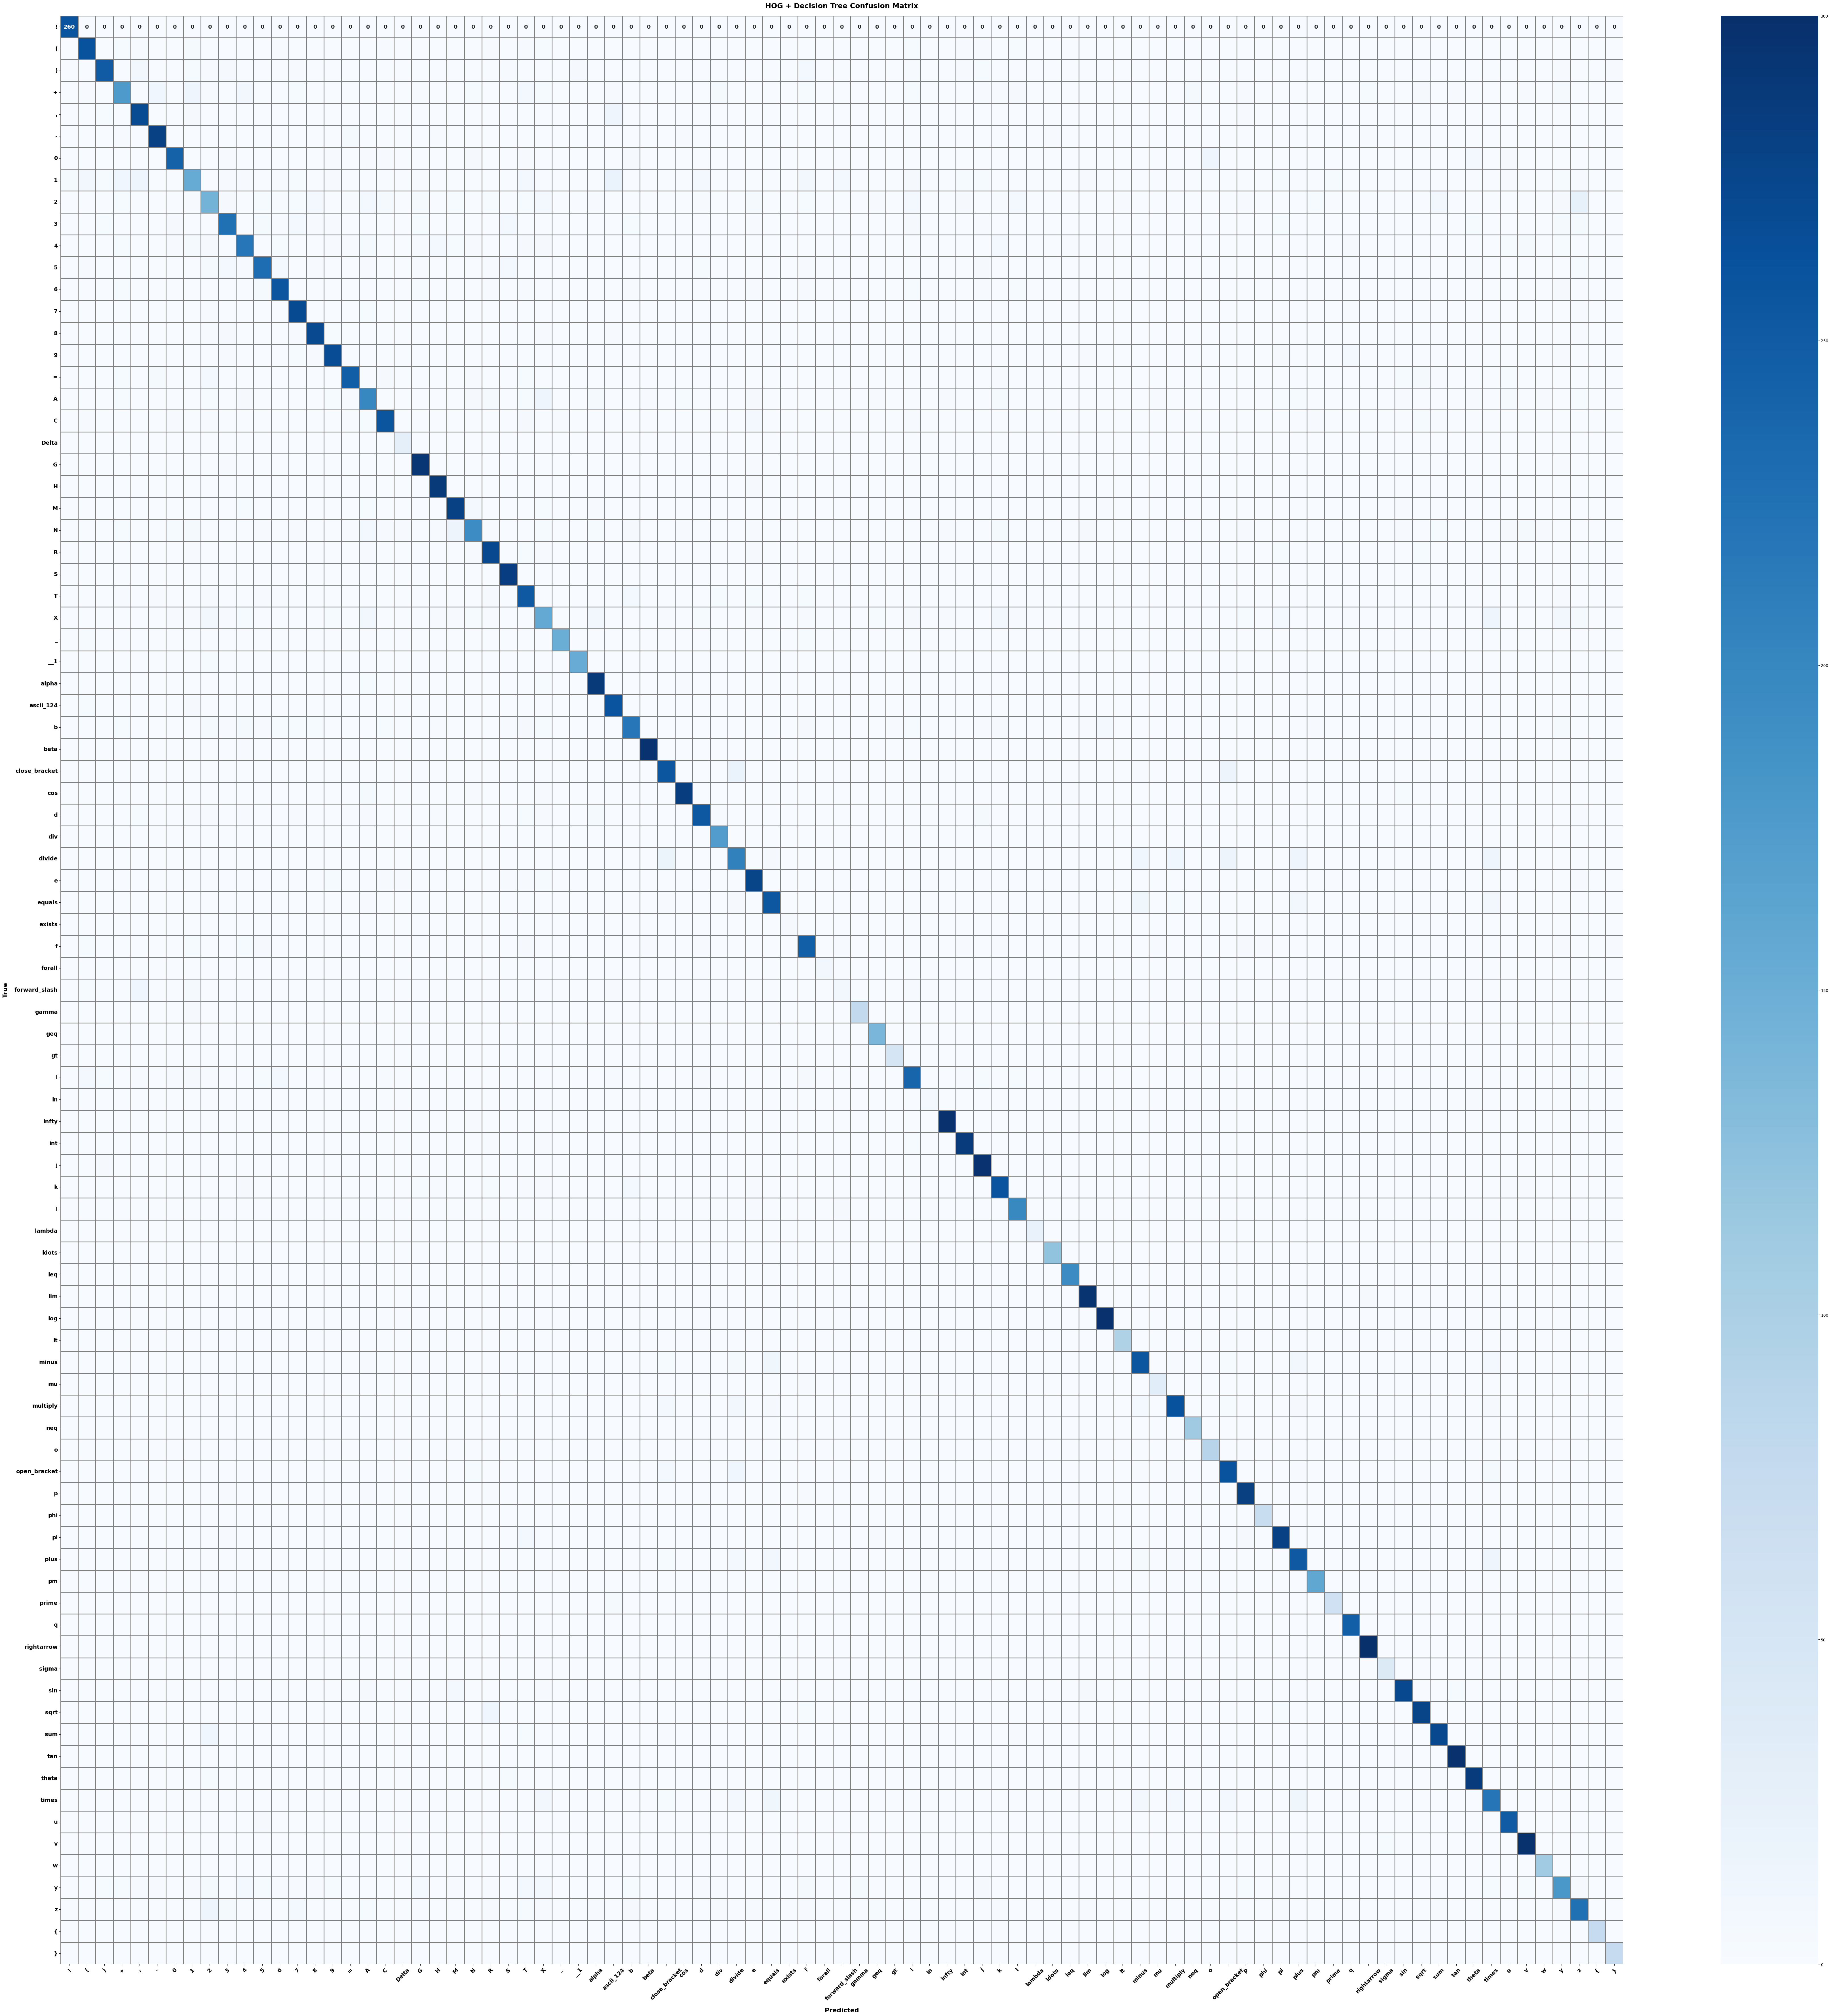

Analysis: Decision Tree with HOG achieved 86.99% accuracy. Cohen's Kappa = 0.87, meaning 86.8% agreement beyond chance.


========== GLCM + Decision Tree ==========
Accuracy: 0.8015
Cohen's Kappa: 0.7988

Classification Report:
               precision    recall  f1-score   support

            !       0.97      1.00      0.98       260
            (       0.61      0.56      0.59       300
            )       0.67      0.55      0.60       300
            +       0.66      0.51      0.58       300
            ,       0.80      0.90      0.85       300
            -       0.98      0.94      0.96       300
            0       0.65      0.57      0.61       300
            1       0.61      0.42      0.50       300
            2       0.46      0.31      0.37       300
            3       0.65      0.55      0.60       300
            4       0.71      0.59      0.64       300
            5       0.68      0.64      0.66       300
            6       0.76      0.73      0.74       300
 

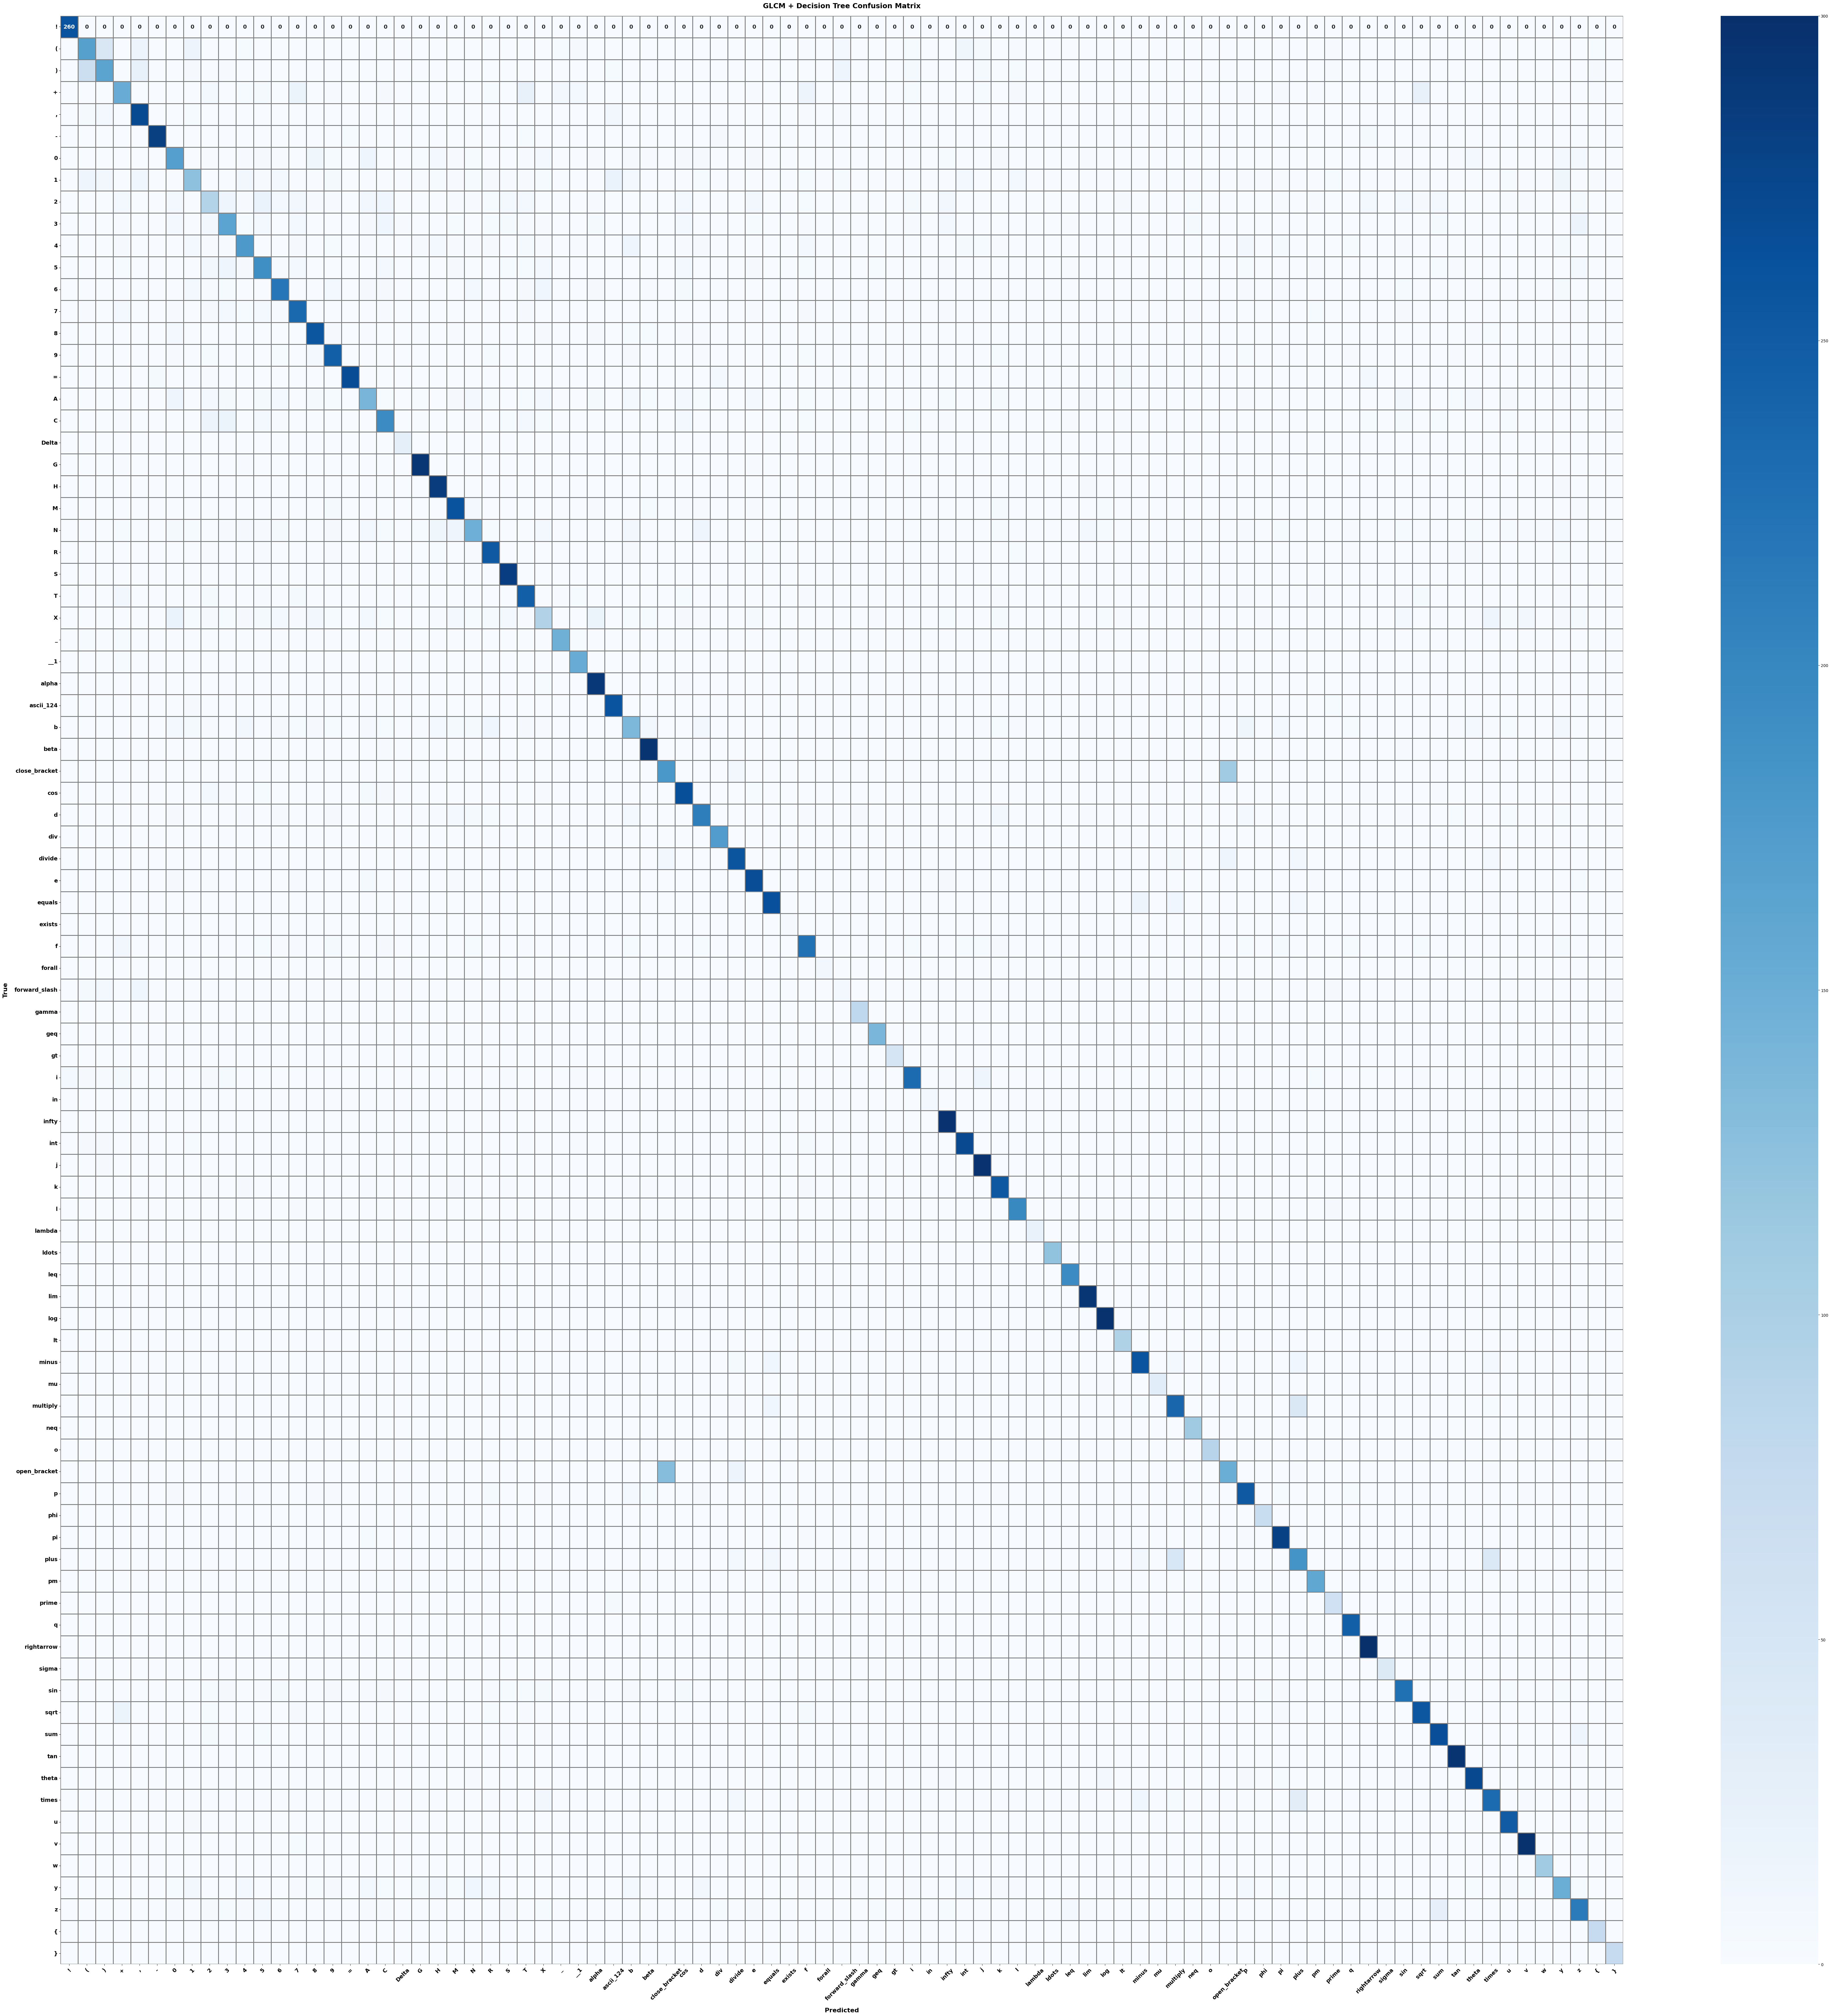

Analysis: Decision Tree with GLCM achieved 80.15% accuracy. Cohen's Kappa = 0.80, meaning 79.9% agreement beyond chance.


========== SIFT + Decision Tree ==========
Accuracy: 0.6699
Cohen's Kappa: 0.6655

Classification Report:
               precision    recall  f1-score   support

            !       0.85      0.95      0.90       260
            (       0.64      0.53      0.58       300
            )       0.61      0.51      0.55       300
            +       0.41      0.31      0.35       300
            ,       0.71      0.80      0.75       300
            -       0.58      0.45      0.51       300
            0       0.52      0.45      0.48       300
            1       0.38      0.27      0.32       300
            2       0.37      0.26      0.31       300
            3       0.58      0.48      0.53       300
            4       0.58      0.55      0.56       300
            5       0.71      0.61      0.66       300
            6       0.70      0.68      0.69       300


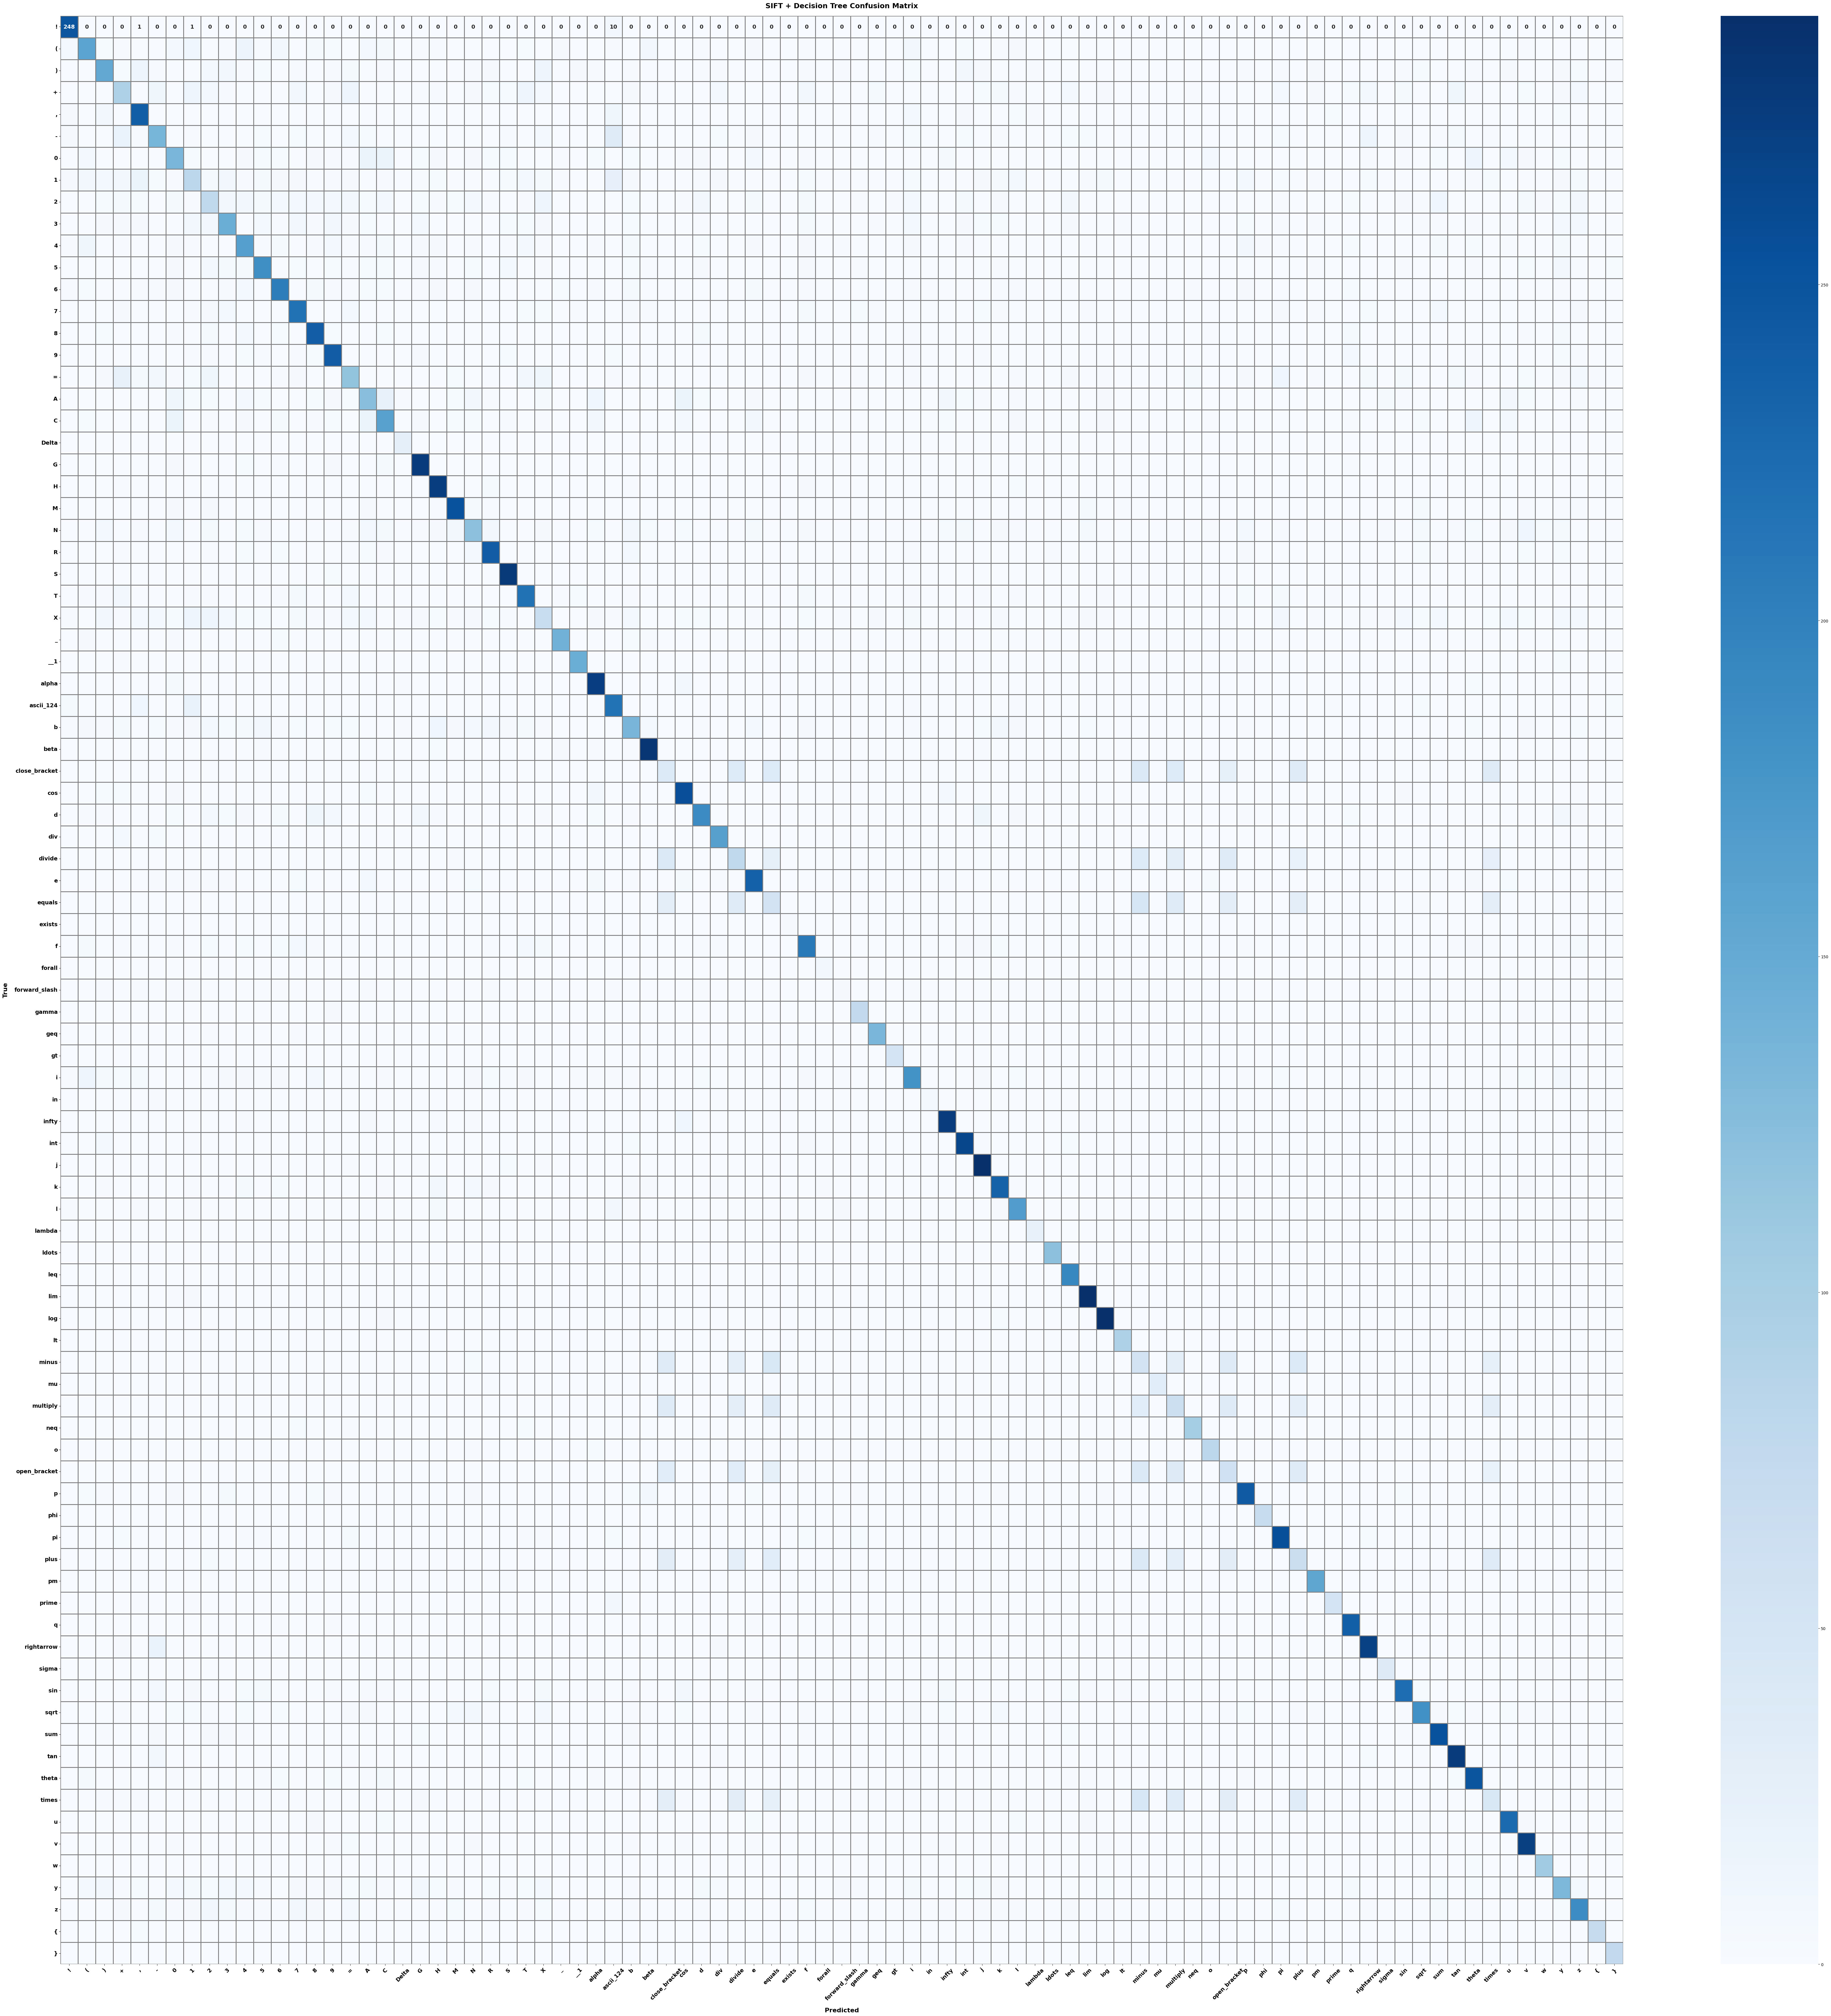

Analysis: Decision Tree with SIFT achieved 66.99% accuracy. Cohen's Kappa = 0.67, meaning 66.5% agreement beyond chance.



In [6]:
# ===================== BLOCK 6: RUN EVALUATIONS =====================
evaluate_model(X_train_hog, X_test_hog, y_train, y_test, "HOG", class_mapping)
evaluate_model(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM", class_mapping)
evaluate_model(X_train_sift, X_test_sift, y_train, y_test, "SIFT", class_mapping)


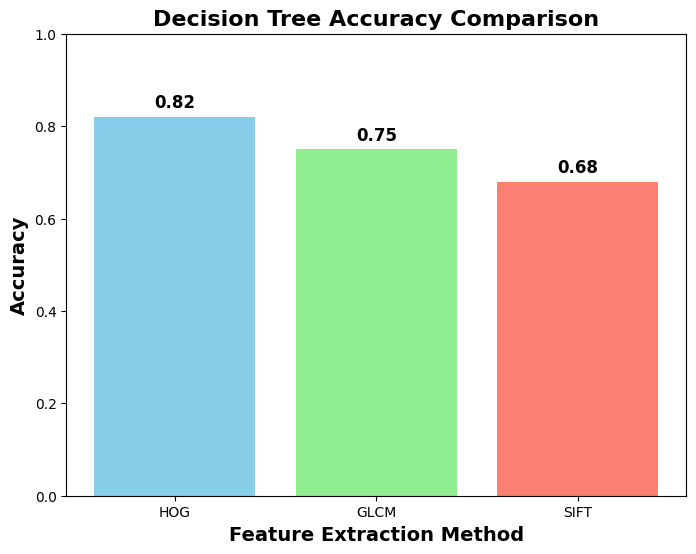

In [10]:
# ===================== BLOCK 7: BAR GRAPH (Manual Version) =====================
import matplotlib.pyplot as plt

# 🚨 Replace these with the accuracies you saw in Block 6 output
hog_acc = 0.82   # example
glcm_acc = 0.75  # example
sift_acc = 0.68  # example

# Collect into dictionary
dt_acc = {
    "HOG": hog_acc,
    "GLCM": glcm_acc,
    "SIFT": sift_acc
}

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(dt_acc.keys(), dt_acc.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Decision Tree Accuracy Comparison", fontsize=16, weight="bold")
plt.xlabel("Feature Extraction Method", fontsize=14, weight="bold")
plt.ylabel("Accuracy", fontsize=14, weight="bold")
plt.ylim(0, 1.0)  # keep scale between 0–1
for i, v in enumerate(dt_acc.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, weight="bold")
plt.show()



--- Random Forest on HOG ---
✅ Accuracy: 0.9551

Classification Report:
               precision    recall  f1-score   support

            !       1.00      1.00      1.00       260
            (       0.91      0.97      0.94       300
            )       0.95      0.96      0.95       300
            +       0.91      0.93      0.92       300
            ,       0.85      0.95      0.90       300
            -       0.97      0.99      0.98       300
            0       0.93      0.93      0.93       300
            1       0.85      0.66      0.74       300
            2       0.85      0.81      0.83       300
            3       0.92      0.90      0.91       300
            4       0.94      0.92      0.93       300
            5       0.97      0.88      0.92       300
            6       0.92      0.97      0.94       300
            7       0.98      0.95      0.96       300
            8       0.93      0.98      0.95       300
            9       0.92      0.96      0.94  

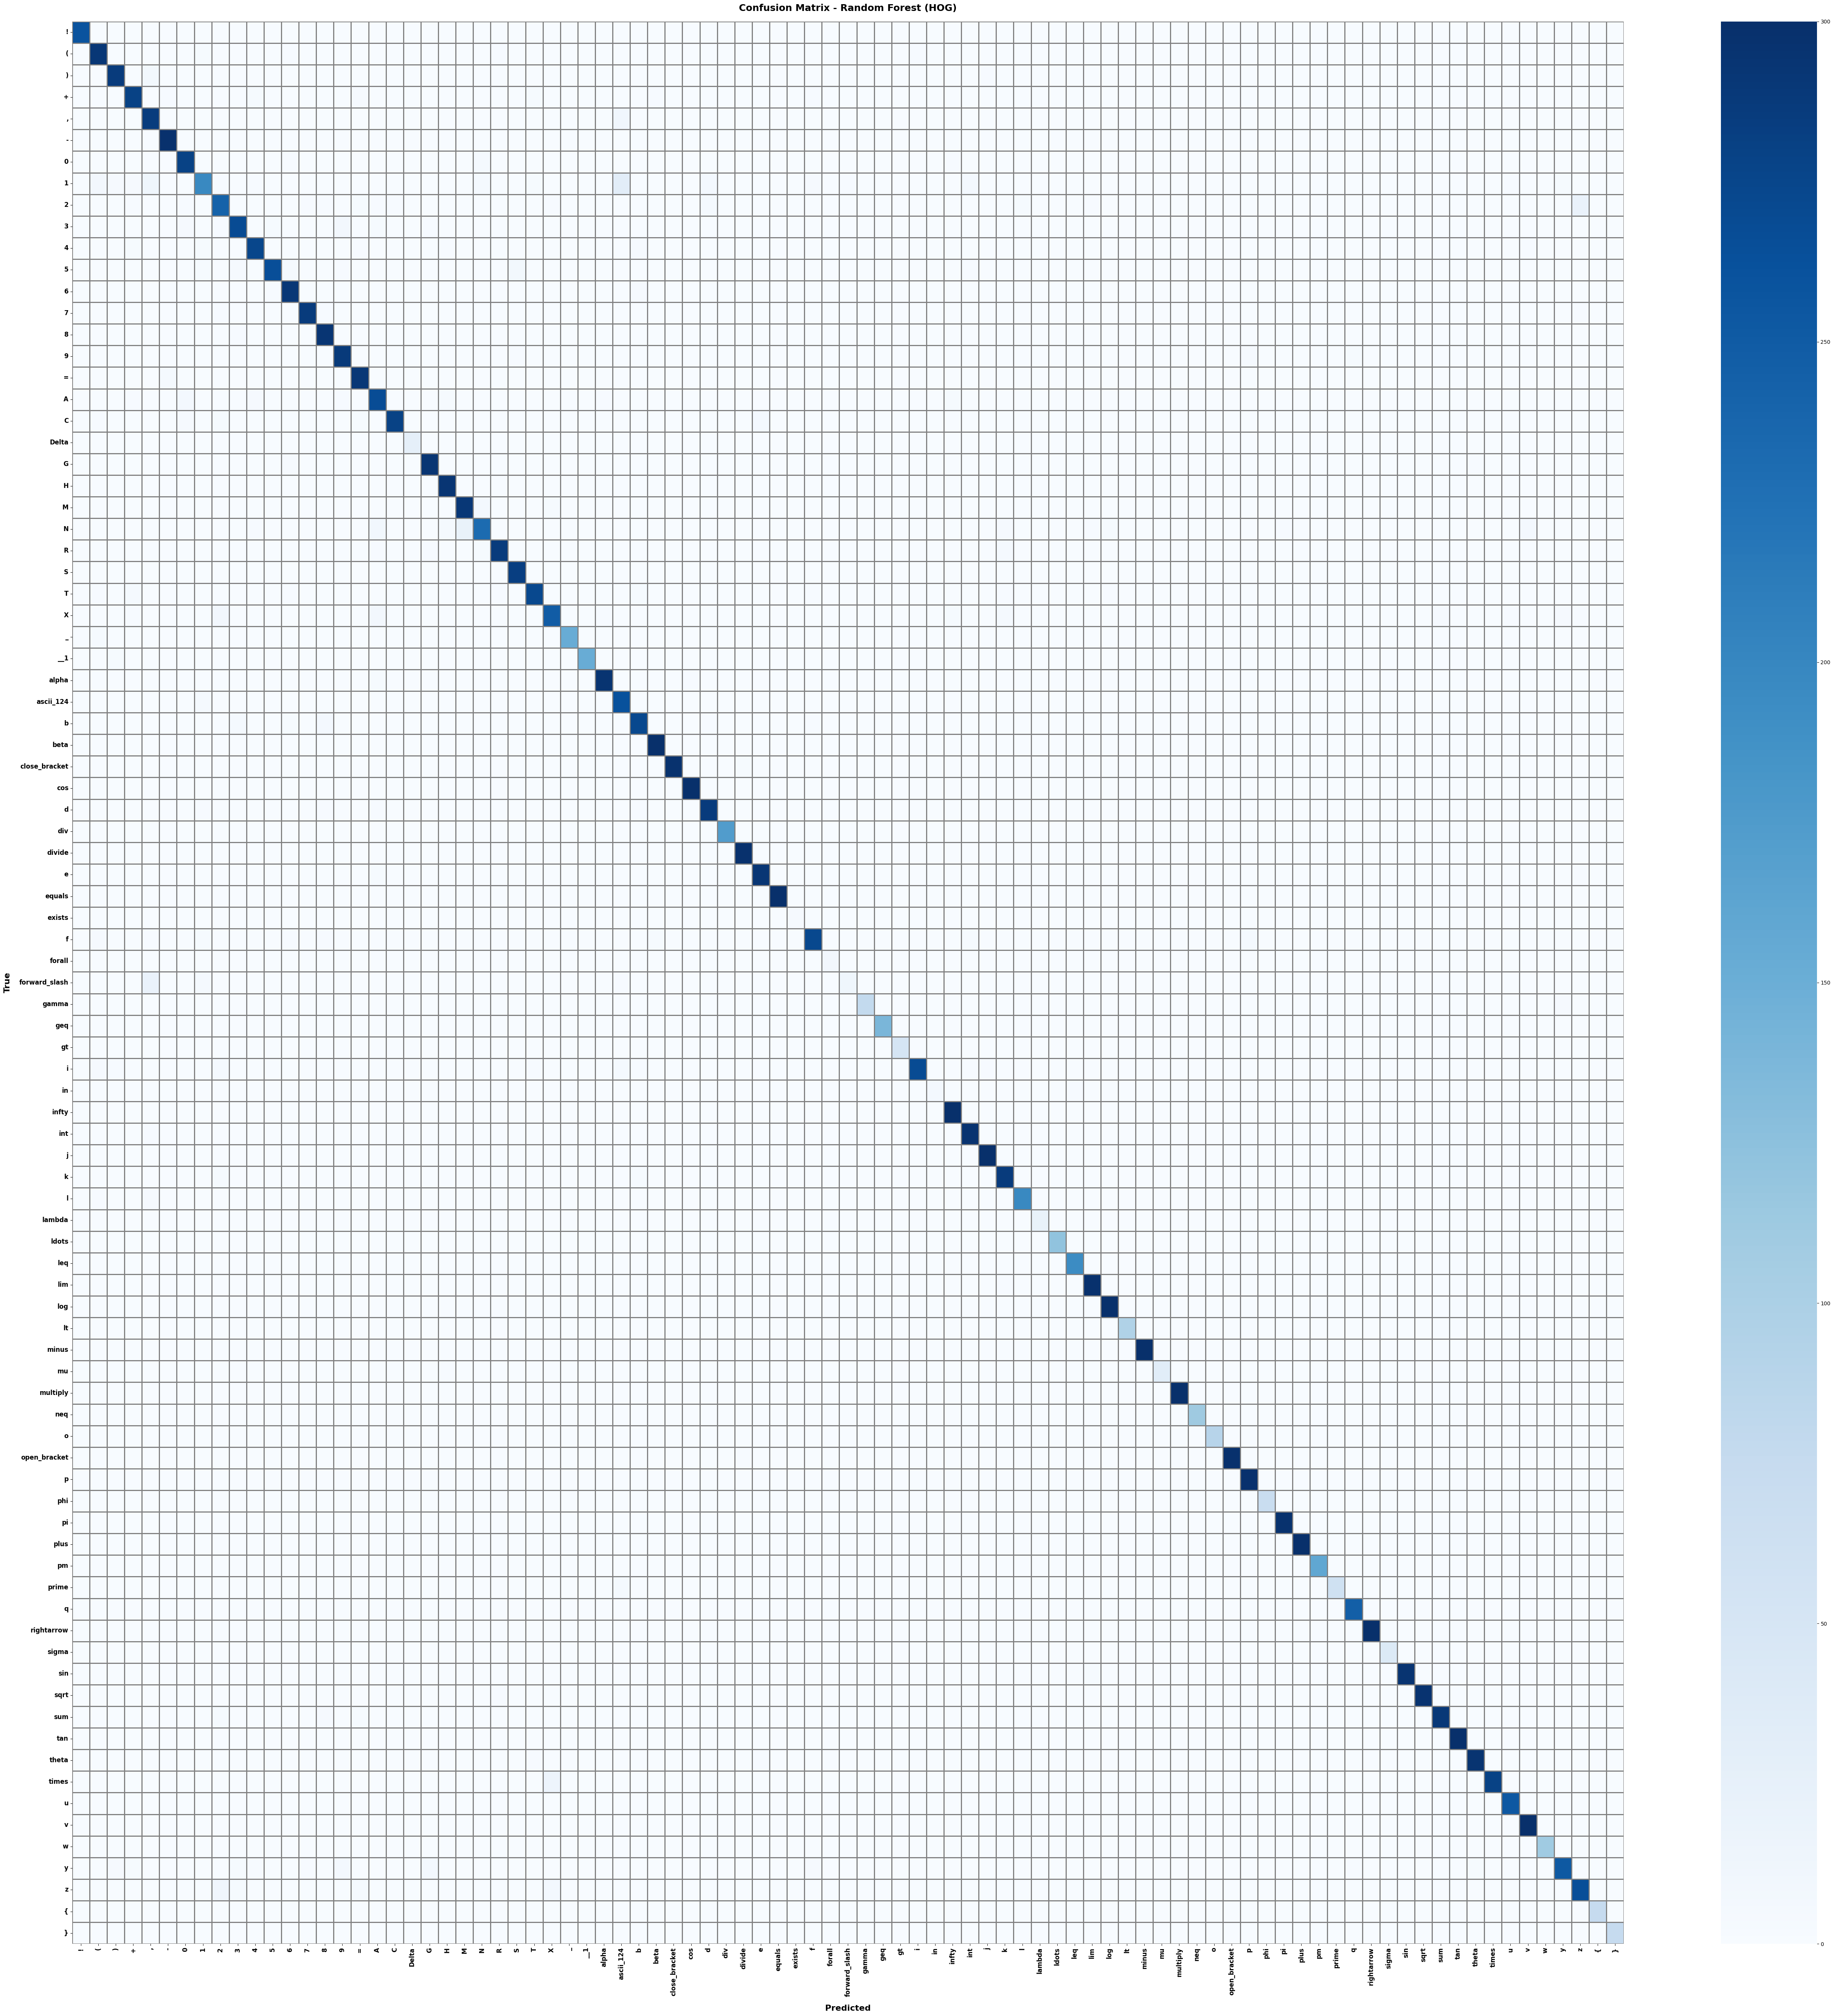


--- Random Forest on GLCM ---
✅ Accuracy: 0.8211

Classification Report:
               precision    recall  f1-score   support

            !       0.96      1.00      0.98       260
            (       0.63      0.72      0.67       300
            )       0.73      0.64      0.68       300
            +       0.71      0.67      0.69       300
            ,       0.85      0.90      0.87       300
            -       0.99      0.98      0.98       300
            0       0.66      0.59      0.62       300
            1       0.65      0.40      0.50       300
            2       0.51      0.30      0.38       300
            3       0.60      0.58      0.59       300
            4       0.75      0.63      0.69       300
            5       0.75      0.65      0.70       300
            6       0.76      0.81      0.78       300
            7       0.77      0.80      0.78       300
            8       0.78      0.89      0.83       300
            9       0.81      0.83      0.82 

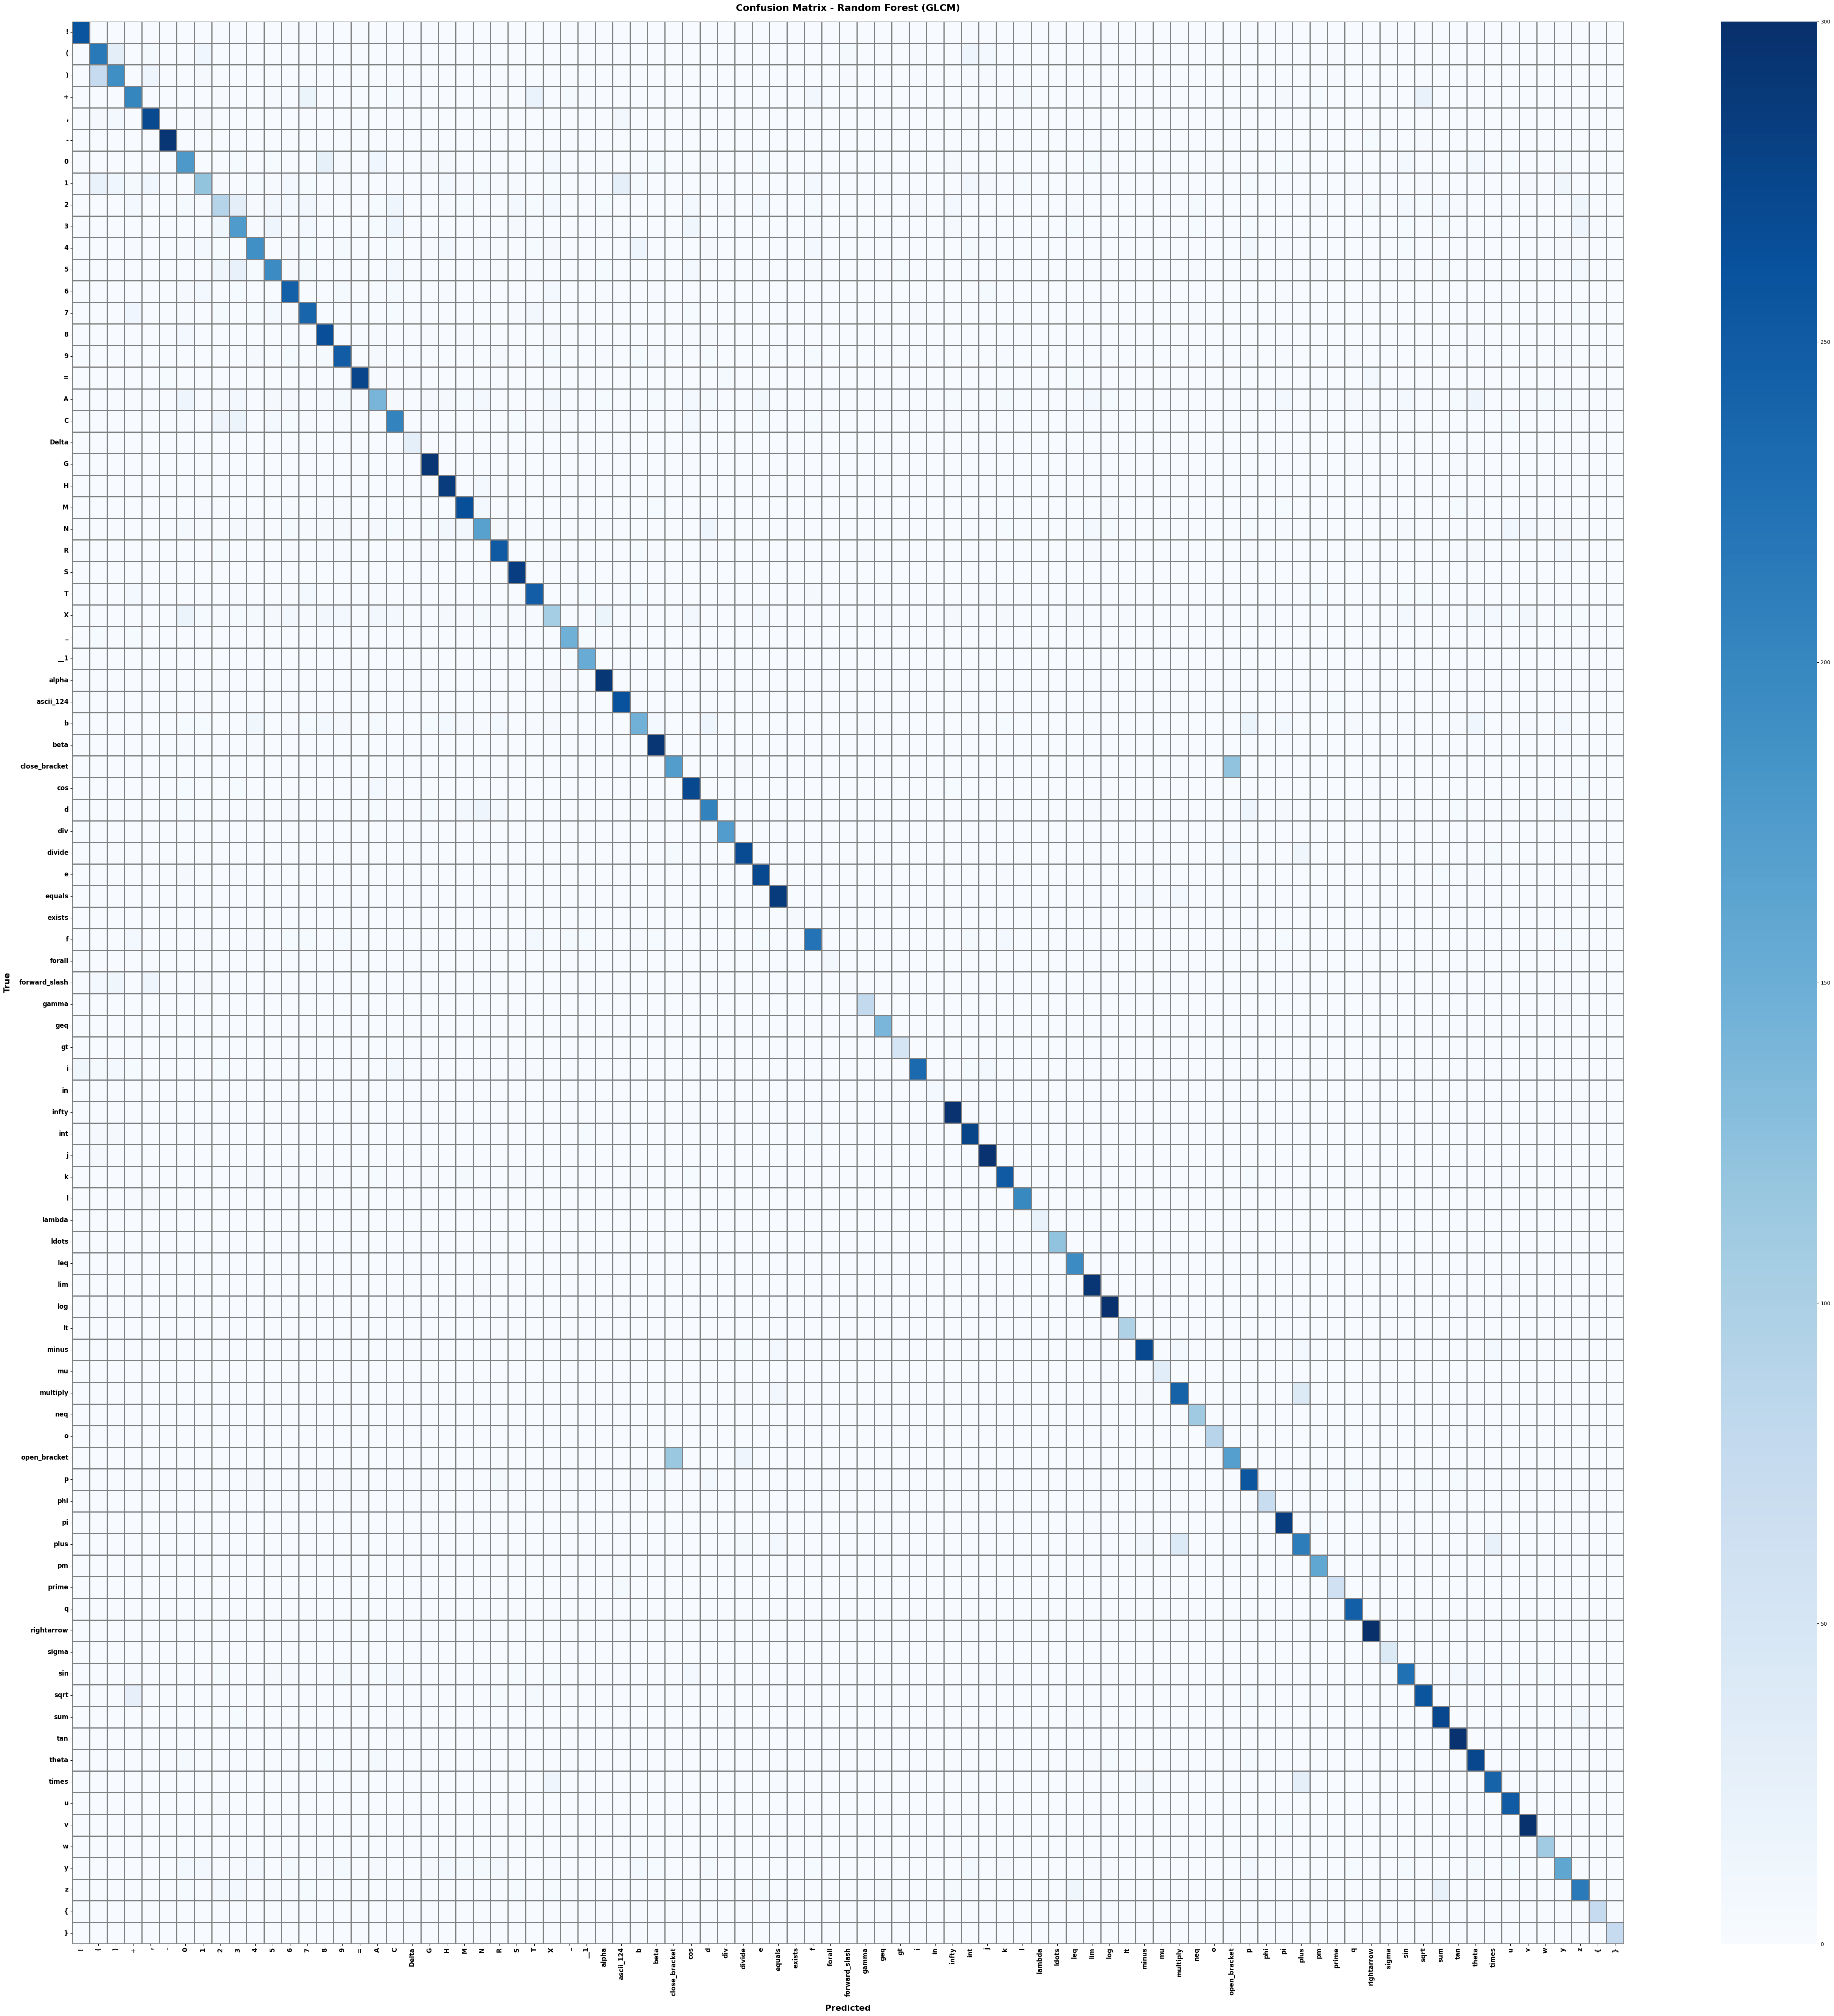


--- Random Forest on SIFT ---
✅ Accuracy: 0.6844

Classification Report:
               precision    recall  f1-score   support

            !       0.87      0.95      0.91       260
            (       0.66      0.62      0.64       300
            )       0.65      0.59      0.62       300
            +       0.42      0.30      0.35       300
            ,       0.75      0.77      0.76       300
            -       0.64      0.50      0.56       300
            0       0.60      0.40      0.48       300
            1       0.43      0.29      0.35       300
            2       0.39      0.26      0.31       300
            3       0.57      0.49      0.53       300
            4       0.61      0.55      0.58       300
            5       0.70      0.62      0.66       300
            6       0.74      0.70      0.72       300
            7       0.68      0.72      0.70       300
            8       0.75      0.80      0.77       300
            9       0.73      0.81      0.77 

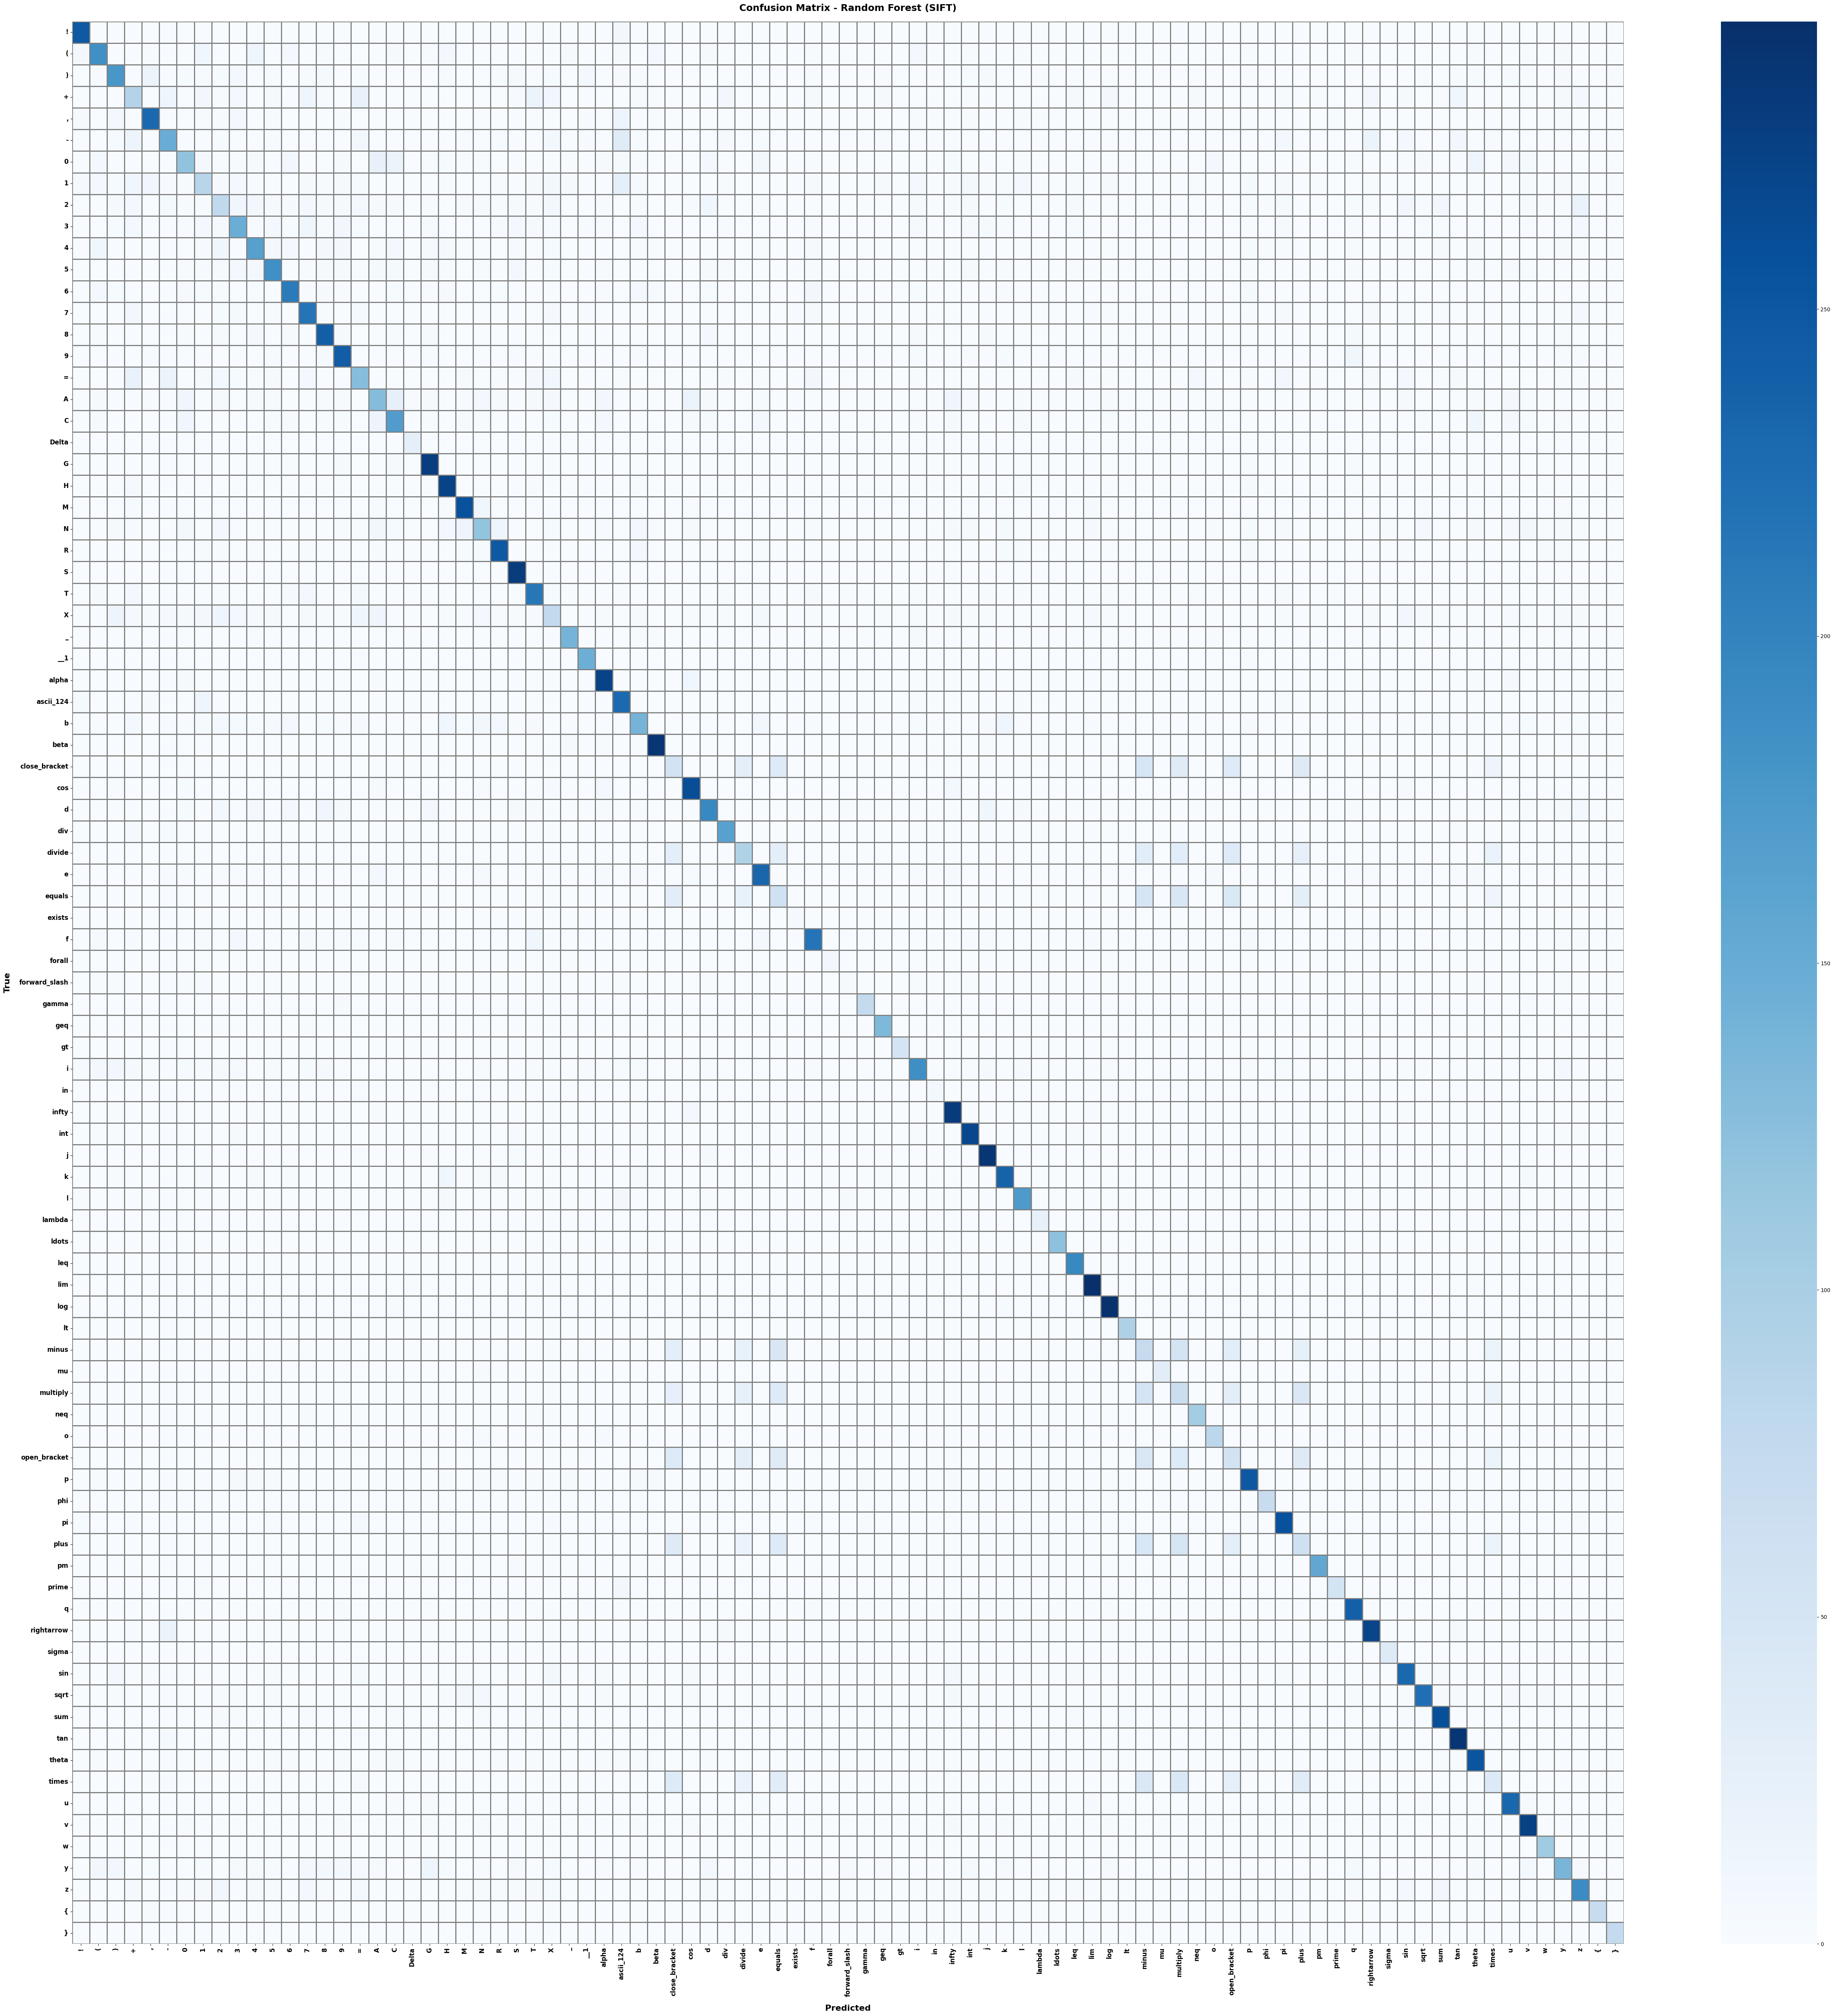


📊 Final Random Forest Accuracies:
HOG: 0.9551
GLCM: 0.8211
SIFT: 0.6844


In [7]:
# ===================== BLOCK RF: RANDOM FOREST (Improved Confusion Matrix) =====================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

rf_results = {}

def evaluate_rf(X_train, X_test, y_train, y_test, feature_name):
    print(f"\n--- Random Forest on {feature_name} ---")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rf_results[feature_name] = acc
    print(f"✅ Accuracy: {acc:.4f}")

    # dynamically pick only labels that appear in either y_test or y_pred
    unique_labels = np.unique(np.concatenate([y_test, y_pred]))

    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred,
        labels=unique_labels,
        target_names=[class_mapping[i] for i in unique_labels],
        zero_division=0
    ))

    # Confusion Matrix (expanded & clearer)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    num_classes = len(unique_labels)
    plt.figure(figsize=(max(20, num_classes*0.6), max(16, num_classes*0.6)))
    sns.heatmap(
        cm, annot=False, cmap="Blues", cbar=True,
        xticklabels=[class_mapping[i] for i in unique_labels],
        yticklabels=[class_mapping[i] for i in unique_labels],
        linewidths=0.8, linecolor="gray"
    )

    plt.xticks(rotation=90, fontsize=12, weight="bold")
    plt.yticks(rotation=0, fontsize=12, weight="bold")

    plt.title(f"Confusion Matrix - Random Forest ({feature_name})", fontsize=18, weight="bold", pad=20)
    plt.xlabel("Predicted", fontsize=16, weight="bold", labelpad=15)
    plt.ylabel("True", fontsize=16, weight="bold", labelpad=15)

    plt.tight_layout()
    plt.show()


# Run on each feature set
evaluate_rf(X_train_hog, X_test_hog, y_train, y_test, "HOG")
evaluate_rf(X_train_glcm, X_test_glcm, y_train, y_test, "GLCM")
evaluate_rf(X_train_sift, X_test_sift, y_train, y_test, "SIFT")

print("\n📊 Final Random Forest Accuracies:")
for feat, acc in rf_results.items():
    print(f"{feat}: {acc:.4f}")


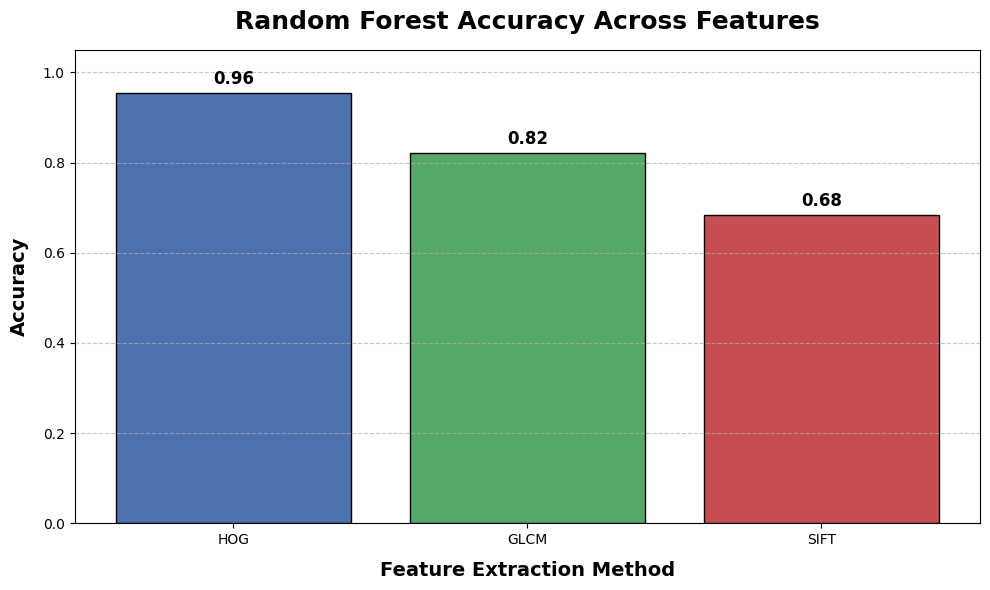

In [8]:
# ===================== BLOCK B: BAR GRAPH OF RF ACCURACIES =====================
plt.figure(figsize=(10, 6))

# Bar plot of accuracies
plt.bar(rf_results.keys(), rf_results.values(), color=["#4C72B0", "#55A868", "#C44E52"], edgecolor="black")

# Labels & formatting
plt.title("Random Forest Accuracy Across Features", fontsize=18, weight="bold", pad=15)
plt.xlabel("Feature Extraction Method", fontsize=14, weight="bold", labelpad=10)
plt.ylabel("Accuracy", fontsize=14, weight="bold", labelpad=10)
plt.ylim(0, 1.05)

# Annotate each bar with accuracy value
for i, (feat, acc) in enumerate(rf_results.items()):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center", fontsize=12, weight="bold")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
